In [1]:
# The Python waveformdatabase package (wfdb) is a A library of tools for 
# reading, writing, and processing WFDB signals and annotations.
# https://github.com/MIT-LCP/wfdb-python
import wfdb
import audio_utilities
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def get_ptb_data(controls, num_samples, sample_length, channel_num):
    """This function reads patient numbers and data file names from controls.txt,
       and uses them to query the Physiobank ptbdb dataset.
       
    Parameters:
        controls: boolean, used to specify whether control data or not is returned.
        num_samples: number of waveforms to return
        sample_length: number of data points to return
        channel_num: which of the EKG channels to return (classic heartbeat is channel 3, index 2)
    
    Returns:
        List of 1-dim numpy arrays of time-series EKG wavefrom.
    """
    
    ptb_entries = []
    ptb_data = []
    if controls:
        with open ("data/controls.txt", "r") as controlsFile:
            for line in controlsFile:
                ptb_entries.append(line.strip("\n").split("/"))
        for ptb_entry in ptb_entries[0:num_samples]:
            signal, fields = wfdb.rdsamp(ptb_entry[1], channels=[channel_num], sampfrom=0, sampto=sample_length, pb_dir='ptbdb/' + ptb_entry[0])
            x = signal.flatten()
            ptb_data.append(x);
    return ptb_data

In [18]:
# Taken from https://github.com/bkvogel/griffin_lim under FreeBSD License
def stft_for_reconstruction(x, fft_size, hopsamp):
    """Compute and return the STFT of the supplied time domain signal x.

    Args:
        x (1-dim Numpy array): A time domain signal.
        fft_size (int): FFT size. Should be a power of 2, otherwise DFT will be used.
        hopsamp (int):

    Returns:
        The STFT. The rows are the time slices and columns are the frequency bins.
    """
    window = np.hanning(fft_size)
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    return np.array([np.fft.rfft(window*x[i:i+fft_size])
                     for i in range(0, len(x)-fft_size, hopsamp)])

In [19]:
# Taken from https://github.com/bkvogel/griffin_lim under FreeBSD License
def istft_for_reconstruction(X, fft_size, hopsamp):
    """Invert a STFT into a time domain signal.

    Args:
        X (2-dim Numpy array): Input spectrogram. The rows are the time slices and columns are the frequency bins.
        fft_size (int):
        hopsamp (int): The hop size, in samples.

    Returns:
        The inverse STFT.
    """
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    window = np.hanning(fft_size)
    time_slices = X.shape[0]
    len_samples = int(time_slices*hopsamp + fft_size)
    x = np.zeros(len_samples)
    for n,i in enumerate(range(0, len(x)-fft_size, hopsamp)):
        x[i:i+fft_size] += window*np.real(np.fft.irfft(X[n]))
    return x

In [20]:
data = get_ptb_data(controls=True, num_samples=2, sample_length=4096, channel_num=2)

In [21]:
fft_length = 64
fft_hop = 16

In [22]:
spectrogram = stft_for_reconstruction(data[0], fft_length, fft_hop).T
# take the square root for better color contrast 
spectrogram_mag_sqrt = np.absolute(spectrogram)**2
spectrogram_mag = np.absolute(spectrogram)

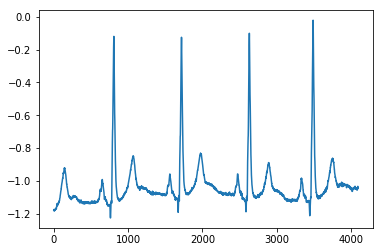

In [23]:
plt.plot(data[0])

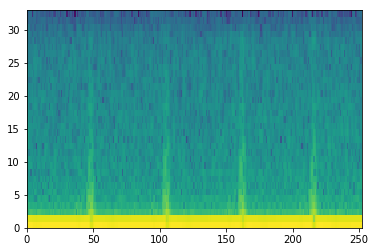

In [24]:
# Showing the log of the spectral power for better contrast
plt.pcolormesh(np.log(spectrogram_mag[:,:]**2))

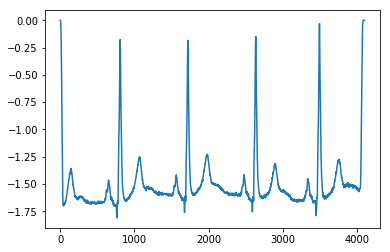

In [25]:
# Use the inverse short time fourier transform to reconstruct the waveform 
reconstructed = istft_for_reconstruction(spectrogram.T, fft_length, fft_hop)
plt.plot(reconstructed)

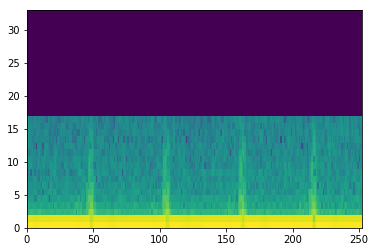

In [26]:
# Experiment: remove the high frequency noise, and see what the reconstruction looks like
# Less frequency information => less nodes in generative model => faster training
low_freq_spectrogram = spectrogram
low_freq_spectrogram[17:,:]= 0
low_freq_mag = np.absolute(low_freq_spectrogram) + 10e-6
plt.pcolormesh(np.log(low_freq_mag))

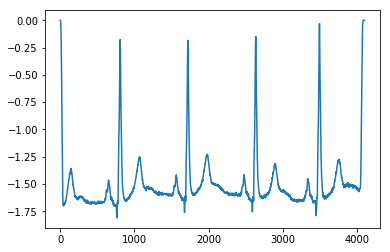

In [27]:
reconstructed_low_freq = istft_for_reconstruction(low_freq_spectrogram.T, fft_length, fft_hop)
plt.plot(reconstructed)